# **Post-Hoc Concept Bottleneck Models User Study Replication**

This file contains essentially all the scripts necessary to replicate the results we obtained for reproducing the claim that *PCBMs allow for global model editing.* The scripts for the other experiments can be found [here instead](main.ipynb).

Before starting, all the necessary files need to first be prepared. This notebook, when run, will setup all the necessary installations in the environment. We need to first move outside of the `\notebook` directory via the code block below. It should automatically setup the directory depending on whether this notebook is being run locally or on Google Colab.

**Extra Note:** In many cells, the following part (`!PYTHONPATH=models:.:$PYTHONPATH NO_AUDIOCLIP=1`) exists due to the importing of AudioCLIP in the files which have this snippet in front of them. Currently, the only way to not have to use this is by downloading the AudioCLIP dependencies. This is due to how the repository is setup, with the snippet being a workaround due to time constraints.

In [ ]:
import os
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import userdata
    repo_name = 'write repository name here'
    url = f"https://{userdata.get('gh_pat')}@github.com/{repo_name}.git" # Note: may need to be scrubbed
    !git clone {url}
    !pip install git+https://github.com/openai/CLIP.git # for the CLIP library
    print("\nCurrent Directory:")
    %cd FACT
    !pip install -r requirements.txt

else: # automatically checks if the current directory is 'FACT'
    curdir = Path.cwd()
    print("Current Directory", curdir)
    assert curdir.name == "FACT" or curdir.parent.name == "FACT", "Notebook cwd has to be on the project root"
    if curdir.name == "notebooks":
        %cd ..
        print("New Current Directory:", curdir)

Also, for this notebook specifically, we require the `datasets` package.

In [ ]:
!pip install datasets

...and now we can load the dependencies.

_Note:_ You need to also setup a HuggingFace token in Colab beforehand.

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
token = userdata.get('huggingface_token')

## Learning Concepts with Defined Scenario Classes

Here we first learn the concepts for use later for the defined scenario classes.

In [ ]:
!PYTHONPATH=models:.:$PYTHONPATH NO_AUDIOCLIP=1 python learn_concepts_multimodal.py \
  --classes="task_3_bed_cat_all" \
  --class_names="airplane,bed,car,cow,keyboard,dog,beach,bus,bird,cat,motorcycle,couch,painting,computer,snowboard,lamp,pillow,clock,television,fireplace,fork,table,tomato,snow"\
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir

In [ ]:
!PYTHONPATH=models:.:$PYTHONPATH NO_AUDIOCLIP=1 python learn_concepts_multimodal.py \
  --classes="task_3_bed_cat_only" \
  --class_names="beach,car,airplane,bed,bird"\
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir

In [ ]:
!PYTHONPATH=models:.:$PYTHONPATH NO_AUDIOCLIP=1 python learn_concepts_multimodal.py \
  --classes="task_3_bed_cat_spurious" \
  --class_names="beach,car,airplane,bed,bird,cat"\
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir

## Learning concepts with CIFAR100

Here we learn the concepts from the CIFAR100 dataset.

In [ ]:
!PYTHONPATH=models:.:$PYTHONPATH NO_AUDIOCLIP=1 python learn_concepts_multimodal.py \
  --classes="cifar100" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir

In [ ]:
# For reference, the seeds used here are: 42,12,23,34,45,56,67,78,89,100

## **User Study with CIFAR100 Extracted Concepts**

Now we can start with training the PCBMs which have similar weights to the original study. We do this for each scenario as specified in the paper, starting with Scenario 1:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl'\
  --dataset="task_1_bed_dog" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='bed'\
  --token={token}

We can plot these results to view the concept weights. All these plots were used in our user study.

<ipython-input-11-d58f7d6bb21c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


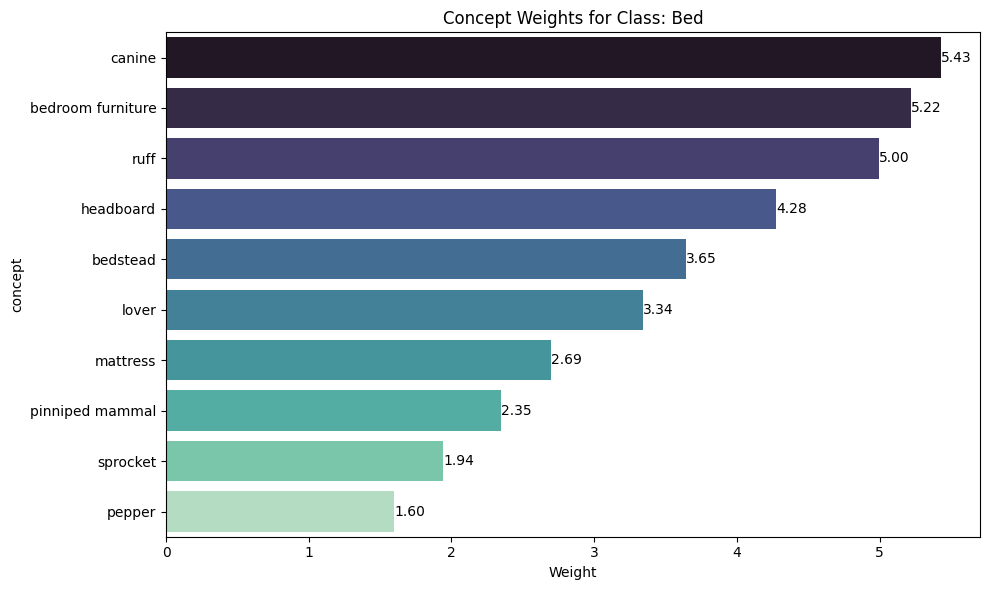

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_1_bed_dog_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'bed'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='mako',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Bed')

plt.tight_layout()
plt.show()

Scenario 2:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_2_keyboard_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='keyboard'\
  --token={token}

<ipython-input-10-01b60fb1de8c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


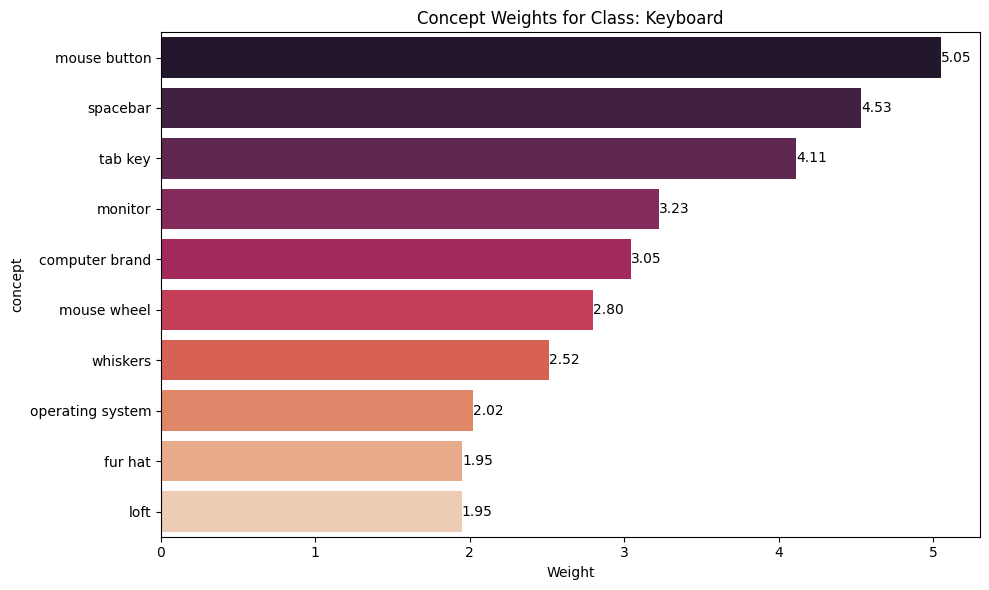

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_2_keyboard_cat_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'keyboard'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='rocket',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')

# Set the labels and title
plt.xlabel('Weight')
plt.title('Concept Weights for Class: Keyboard')

# Show the plot
plt.tight_layout()
plt.show()

Scenario 3:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_3_bed_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='bed'\
  --token={token}

<ipython-input-15-a95361767cfe>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


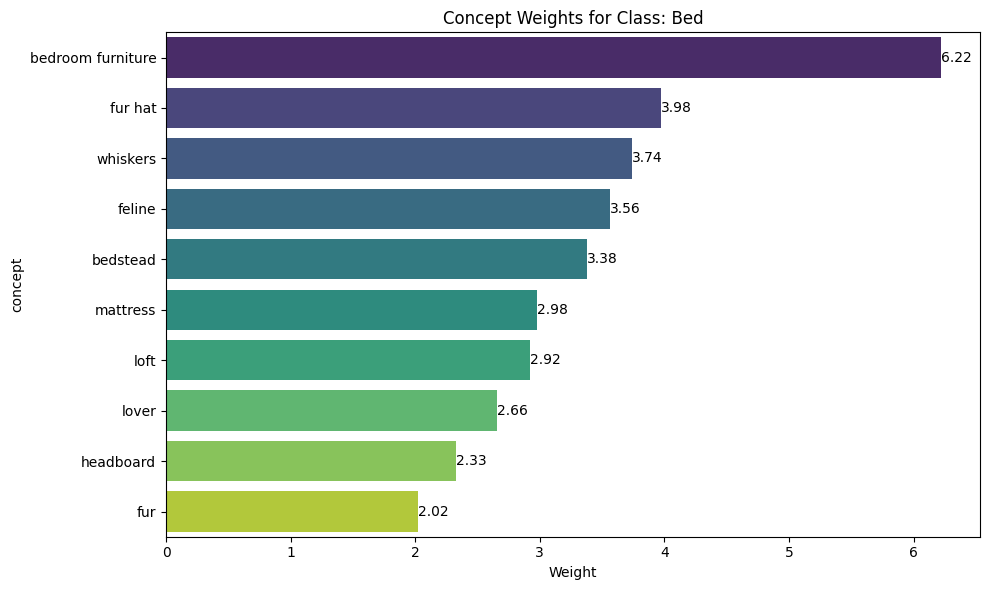

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_3_bed_cat_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'bed'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='viridis',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Bed')

plt.tight_layout()
plt.show()

Scenario 4:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_4_couch_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='couch'\
  --token={token}

<ipython-input-14-aef5275f440b>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


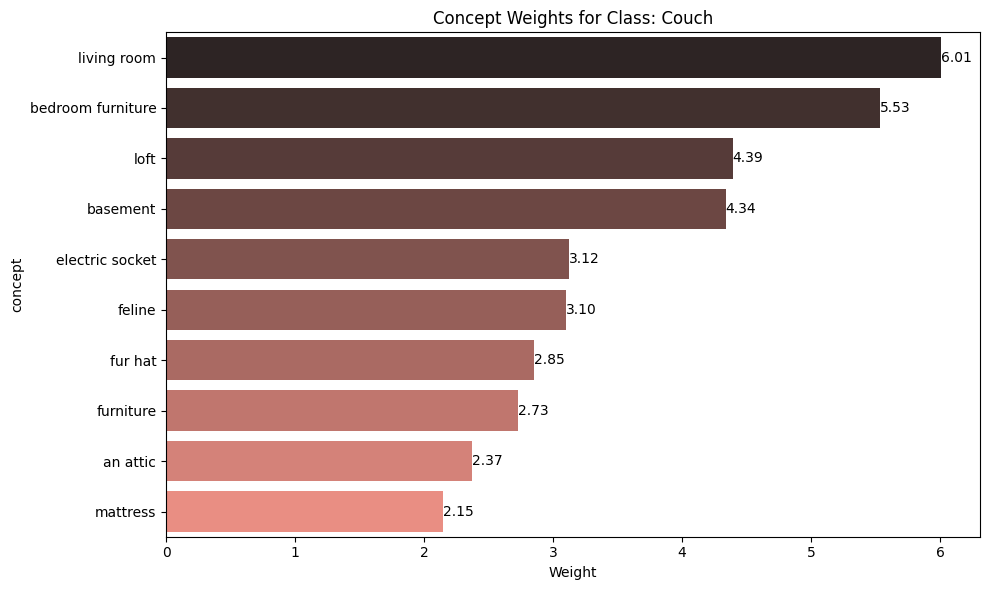

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_4_couch_cat_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'couch'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='dark:salmon',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Couch')

plt.tight_layout()
plt.show()

Scenario 5:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_5_painting_lamp" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='painting'\
  --token={token}

<ipython-input-16-4ba5631830a2>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


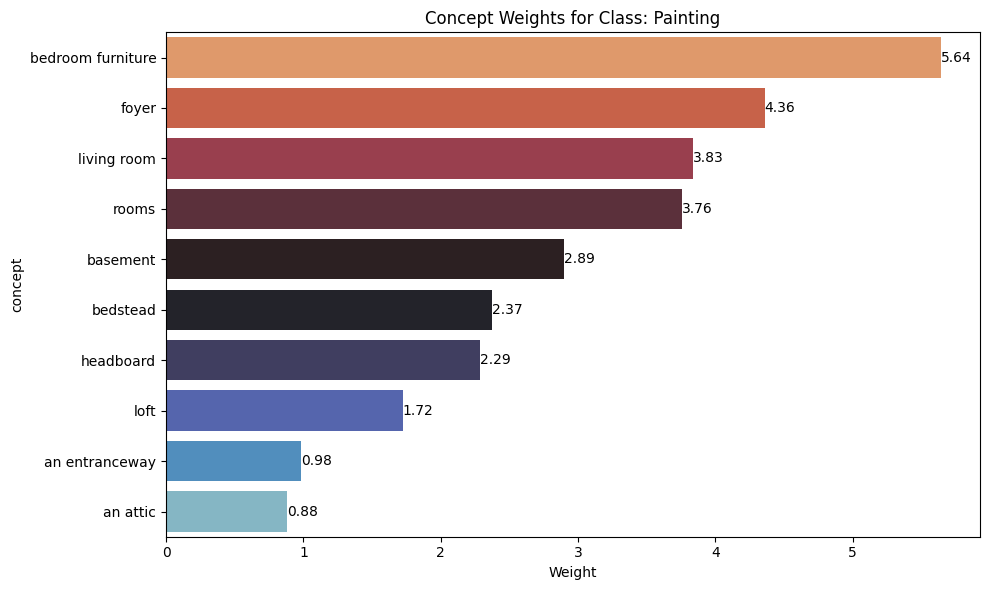

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_5_painting_lamp_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'painting'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='icefire_r',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Painting')

plt.tight_layout()
plt.show()

Scenario 6:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_6_pillow_clock" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,24,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='pillow'\
  --token={token}

<ipython-input-18-cd187fc5c966>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


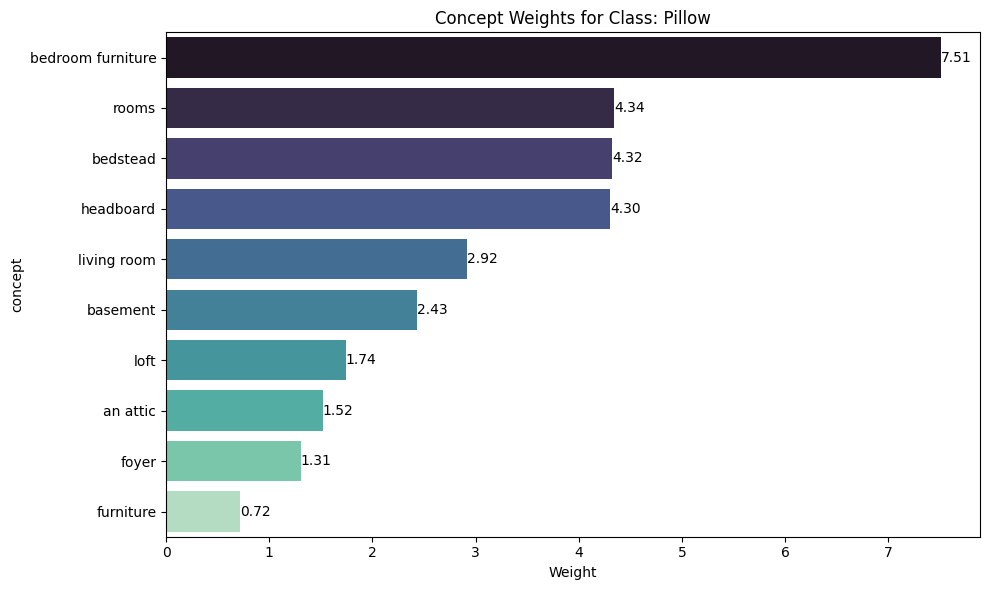

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_6_pillow_clock_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'pillow'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='mako',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Pillow')

plt.tight_layout()
plt.show()

Scenario 7:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_7_television_fireplace" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,24,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='television'\
  --token={token}

<ipython-input-20-b4695ed5c093>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


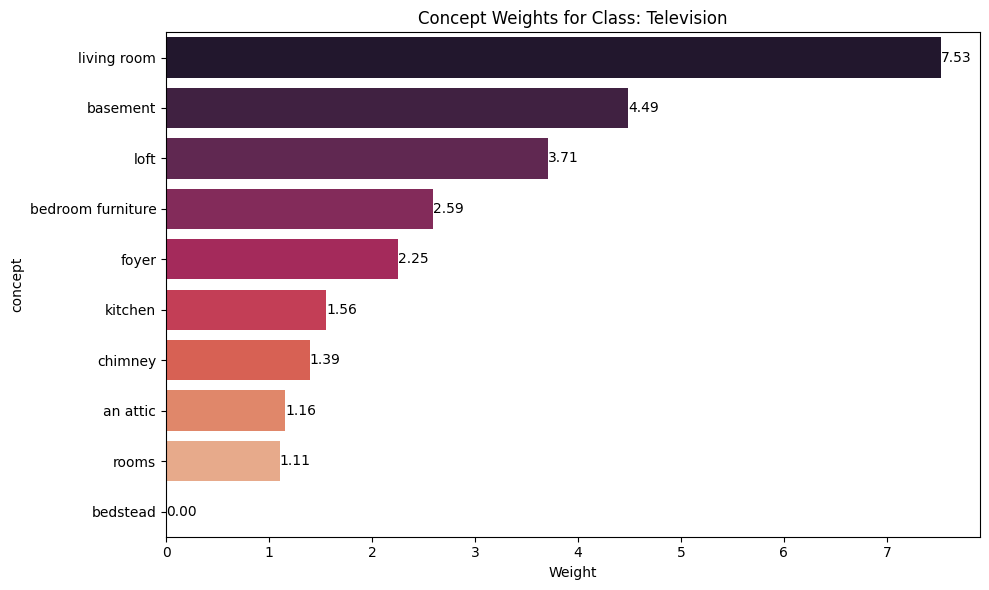

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_7_television_fireplace_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'television'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='rocket',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Television')

plt.tight_layout()
plt.show()

Scenario 8:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_8_fork_tomato" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,24,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='fork'\
  --token={token}

<ipython-input-22-47caefdce1a4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


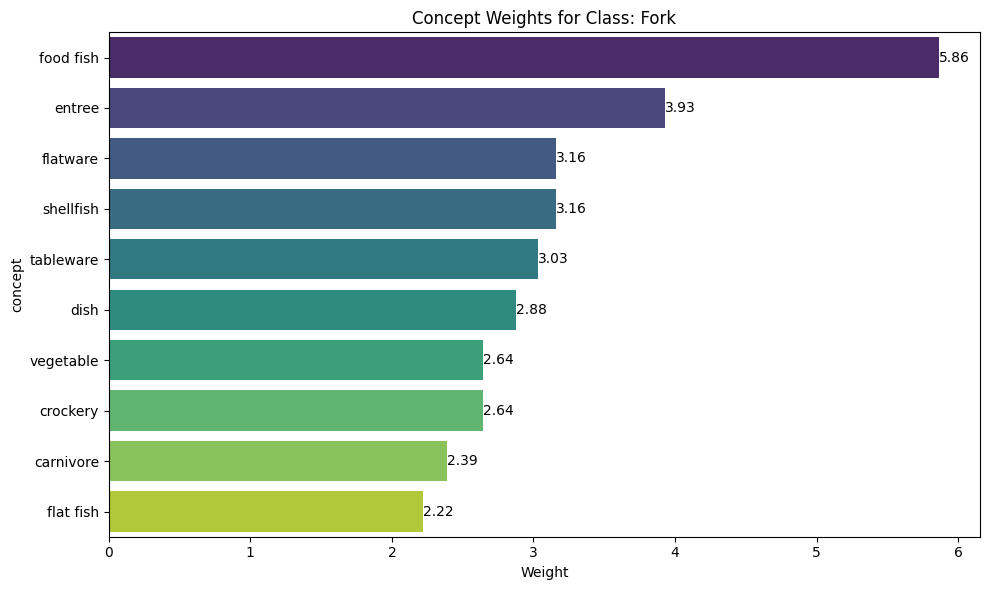

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_8_fork_tomato_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'fork'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='viridis',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Fork')

plt.tight_layout()
plt.show()

...and Scenario 9:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl" \
  --dataset="task_9_car_snow" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,24,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --pruning-class='car'\
  --token={token}

<ipython-input-24-9979e4c2053f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


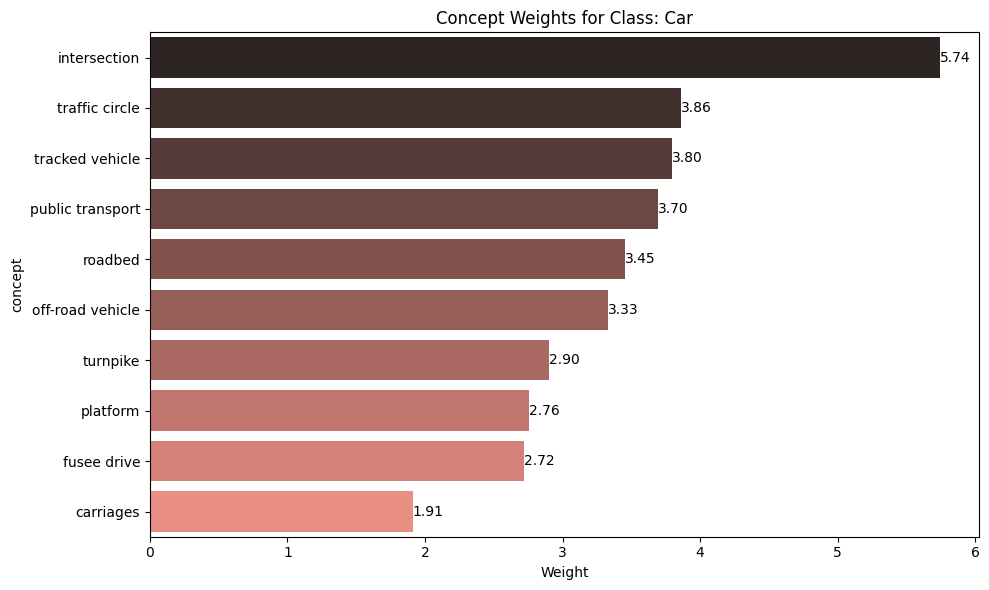

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/task_9_car_snow_weights.csv'
df = pd.read_csv(csv_path)

df_keyboard = df[df['class'] == 'car'].sort_values('weight', ascending=False)

plt.figure(figsize=(10, 6))

barplot = sns.barplot(
    x='weight',
    y='concept',
    data=df_keyboard,
    palette='dark:salmon',
    orient='h'
)
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'left', va = 'center',
                     xytext = (0, 0),
                     textcoords = 'offset points')


plt.xlabel('Weight')
plt.title('Concept Weights for Class: Car')

plt.tight_layout()
plt.show()

# **PCBM-h Evaluation**

We also evaluated the PCBM-h performances of the PCBMs above, again per scenario as mentioned before. We start again with Scenario 1:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_1_bed_dog" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='bed'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 1.769 Avg. Accuracy: 0.219:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 43.94it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.844:   0% 0/8

Scenario 2:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_2_keyboard_cat" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='keyboard'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.524 Avg. Accuracy: 0.797:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 40.83it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.750:   0% 0/8

Scenario 3:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_3_bed_cat" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='bed'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.710 Avg. Accuracy: 0.750:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 43.30it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.766:   0% 0/8

Scenario 4:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_4_couch_cat" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='couch'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.589 Avg. Accuracy: 0.766:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 41.47it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.750:   0% 0/8

Scenario 5:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_5_painting_lamp" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='painting'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.355 Avg. Accuracy: 0.906:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 44.07it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.953:   0% 0/8

Scenario 6:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_6_pillow_clock" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='pillow'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.323 Avg. Accuracy: 0.922:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 43.72it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.953:   0% 0/8

Scenario 7:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_7_television_fireplace" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='television'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.247 Avg. Accuracy: 0.953:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 44.68it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.953:   0% 0/8

Scenario 8:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_8_fork_tomato" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='fork'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.598 Avg. Accuracy: 0.766:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 26.69it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.984:   0% 0/8

...and Scenario 9:

In [ ]:
!python train_pcbm_h_userstudy.py \
--concept-bank="artifacts/outdir/multimodal_concept_clip:RN50_cifar100_recurse:1.pkl"\
--dataset="task_9_car_snow" \
--out-dir=artifacts/outdir\
--num-workers=8 \
--seeds='42,12,23,34,45,56,67,78,89,100'\
--token={token}\
--shifted-class='car'

Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Epoch: 1
  0% 0/8 [00:00<?, ?it/s]
Avg. CELoss: 0.622 Avg. Accuracy: 0.812:   0% 0/8 [00:00<?, ?it/s]
100% 8/8 [00:00<00:00, 43.92it/s]

  0% 0/8 [00:00<?, ?it/s]

  0% 0/8 [00:00<?, ?it/s]
Eval - Avg. Accuracy: 0.750:   0% 0/8

# **Greedy (Oracle) Approach**

Here we have the implementations for the Oracle approach as described in the original paper. The cells below each training run contain tables specifying the exact performance differences compared to the original per seed and number of concepts pruned. Per usual, we start with Scenario 1:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_1_bed_dog" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='bed'\
  --number-of-concepts-to-prune='1,2,3,4,5,6'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'airplane'): 0.93
(1, 'bed'): 0.57
(2, 'car'): 0.94
(3, 'cow'): 0.9
(4, 'keyboard'): 0

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_1_bed_dog.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'bed', 'rank': 10, 'concept': 'pepp...",86.2,84.8,-1.4,57.0,49.000000,-8.000000
1,42,2,"({'class': 'bed', 'rank': 9, 'concept': 'sproc...",86.2,81.2,-5.0,57.0,29.000000,-28.000000
2,42,3,"({'class': 'bed', 'rank': 8, 'concept': 'pinni...",86.2,78.2,-8.0,57.0,14.000000,-43.000000
3,42,4,"({'class': 'bed', 'rank': 5, 'concept': 'headb...",86.2,75.8,-10.4,57.0,2.000000,-55.000000
4,42,5,"({'class': 'bed', 'rank': 6, 'concept': 'lover...",86.2,75.6,-10.6,57.0,1.000000,-56.000000
5,42,6,"({'class': 'bed', 'rank': 1, 'concept': 'canin...",86.2,75.4,-10.8,57.0,0.000000,-57.000000
6,12,1,"({'class': 'bed', 'rank': 10, 'concept': 'long...",84.4,81.2,-3.2,46.0,29.000000,-17.000000
7,12,2,"({'class': 'bed', 'rank': 9, 'concept': 'lover...",84.4,78.8,-5.6,46.0,16.000000,-30.000000
8,12,3,"({'class': 'bed', 'rank': 6, 'concept': 'pinni...",84.4,76.8,-7.6,46.0,6.000000,-40.000000
9,12,4,"({'class': 'bed', 'rank': 3, 'concept': 'ruff'...",84.4,76.0,-8.4,46.0,2.000000,-44.000000


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Scenario 2:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_2_keyboard_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='keyboard'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'beach'): 0.82
(1, 'bus'): 0.95
(2, 'airplane'): 0.92
(3, 'keyboard'): 0.86
(4, 'bird'

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_2_keyboard_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'keyboard', 'rank': 9, 'concept': '...",85.0,83.8,-1.2,86.0,80.0,-6.0
1,42,2,"({'class': 'keyboard', 'rank': 7, 'concept': '...",85.0,82.2,-2.8,86.0,72.0,-14.0
2,42,3,"({'class': 'keyboard', 'rank': 7, 'concept': '...",85.0,77.2,-7.8,86.0,47.0,-39.0
3,42,4,"({'class': 'keyboard', 'rank': 7, 'concept': '...",85.0,72.2,-12.8,86.0,22.0,-64.0
4,42,5,"({'class': 'keyboard', 'rank': 6, 'concept': '...",85.0,69.6,-15.4,86.0,9.0,-77.0
...,...,...,...,...,...,...,...,...,...
85,100,5,"({'class': 'keyboard', 'rank': 5, 'concept': '...",82.0,69.2,-12.8,91.0,18.0,-73.0
86,100,6,"({'class': 'keyboard', 'rank': 5, 'concept': '...",82.0,66.4,-15.6,91.0,4.0,-87.0
87,100,7,"({'class': 'keyboard', 'rank': 1, 'concept': '...",82.0,65.6,-16.4,91.0,0.0,-91.0
88,100,8,"({'class': 'keyboard', 'rank': 1, 'concept': '...",82.0,65.6,-16.4,91.0,0.0,-91.0


Scenario 3:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_3_bed_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='42,12,23,34,45,56,67,78,89,100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='bed'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 42
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 255.63 examples/s]
Generating test spli

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_3_bed_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'bed', 'rank': 10, 'concept': 'fur'...",80.0,80.0,0.0,88.0,86.0,-2.0
1,42,2,"({'class': 'bed', 'rank': 8, 'concept': 'lover...",80.0,78.8,-1.2,88.0,78.0,-10.0
2,42,3,"({'class': 'bed', 'rank': 3, 'concept': 'whisk...",80.0,75.6,-4.4,88.0,62.0,-26.0
3,42,4,"({'class': 'bed', 'rank': 3, 'concept': 'whisk...",80.0,70.6,-9.4,88.0,37.0,-51.0
4,42,5,"({'class': 'bed', 'rank': 3, 'concept': 'whisk...",80.0,64.8,-15.2,88.0,8.0,-80.0
...,...,...,...,...,...,...,...,...,...
65,100,3,"({'class': 'bed', 'rank': 8, 'concept': 'mattr...",82.2,78.2,-4.0,89.0,65.0,-24.0
66,100,4,"({'class': 'bed', 'rank': 4, 'concept': 'fur h...",82.2,73.4,-8.8,89.0,41.0,-48.0
67,100,5,"({'class': 'bed', 'rank': 3, 'concept': 'whisk...",82.2,67.4,-14.8,89.0,11.0,-78.0
68,100,6,"({'class': 'bed', 'rank': 4, 'concept': 'fur h...",82.2,65.4,-16.8,89.0,1.0,-88.0


Scenario 4:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_4_couch_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='couch'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'beach'): 0.69
(1, 'motorcycle'): 0.94
(2, 'airplane'): 0.93
(3, 'couch'): 0.98
(4, '

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_4_couch_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,100,3,"({'class': 'couch', 'rank': 6, 'concept': 'fur...",84.8,82.8,-2.0,98.0,79.0,-19.0


Scenario 5:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_5_painting_lamp" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='painting'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,9,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:02<00:00, 248.47 examples/s]
Generating test spl

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_5_painting_lamp.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'painting', 'rank': 9, 'concept': '...",81.6,81.2,-0.4,53.0,49.0,-4.0
1,42,2,"({'class': 'painting', 'rank': 9, 'concept': '...",81.6,80.8,-0.8,53.0,44.0,-9.0
2,42,3,"({'class': 'painting', 'rank': 8, 'concept': '...",81.6,79.4,-2.2,53.0,36.0,-17.0
3,42,4,"({'class': 'painting', 'rank': 6, 'concept': '...",81.6,77.8,-3.8,53.0,26.0,-27.0
4,42,5,"({'class': 'painting', 'rank': 6, 'concept': '...",81.6,76.4,-5.2,53.0,17.0,-36.0
...,...,...,...,...,...,...,...,...,...
75,100,4,"({'class': 'painting', 'rank': 7, 'concept': '...",81.8,79.2,-2.6,50.0,28.0,-22.0
76,100,5,"({'class': 'painting', 'rank': 5, 'concept': '...",81.8,77.4,-4.4,50.0,19.0,-31.0
77,100,6,"({'class': 'painting', 'rank': 5, 'concept': '...",81.8,75.4,-6.4,50.0,7.0,-43.0
78,100,9,"({'class': 'painting', 'rank': 1, 'concept': '...",81.8,74.0,-7.8,50.0,0.0,-50.0


Scenario 6:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_6_pillow_clock" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='pillow'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'bus'): 0.93
(1, 'pillow'): 0.72
(2, 'cat'): 0.92
(3, 'computer'): 0.78
(4, 'snowboar

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_6_pillow_clock.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'pillow', 'rank': 9, 'concept': 'fo...",85.2,85.4,0.2,72.0,70.0,-2.0
1,42,2,"({'class': 'pillow', 'rank': 9, 'concept': 'fo...",85.2,84.8,-0.4,72.0,66.0,-6.0
2,42,3,"({'class': 'pillow', 'rank': 8, 'concept': 'an...",85.2,83.8,-1.4,72.0,61.0,-11.0
3,42,4,"({'class': 'pillow', 'rank': 6, 'concept': 'ba...",85.2,82.4,-2.8,72.0,52.0,-20.0
4,42,5,"({'class': 'pillow', 'rank': 6, 'concept': 'ba...",85.2,79.8,-5.4,72.0,38.0,-34.0
...,...,...,...,...,...,...,...,...,...
112,420,5,"({'class': 'pillow', 'rank': 6, 'concept': 'fo...",85.8,81.8,-4.0,74.0,43.0,-31.0
113,420,6,"({'class': 'pillow', 'rank': 5, 'concept': 'li...",85.8,77.8,-8.0,74.0,21.0,-53.0
114,420,7,"({'class': 'pillow', 'rank': 2, 'concept': 'he...",85.8,74.4,-11.4,74.0,4.0,-70.0
115,420,8,"({'class': 'pillow', 'rank': 1, 'concept': 'be...",85.8,73.6,-12.2,74.0,0.0,-74.0


Scenario 7:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_7_television_fireplace" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='television'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8,9,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'bus'): 0.99
(1, 'television'): 0.61
(2, 'cat'): 0.94
(3, 'computer'): 0.76
(4, 'snow

In [ ]:
|csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_7_television_fireplace.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'television', 'rank': 10, 'concept'...",81.4,81.4,0.0,47.0,47.0,0.0
1,42,2,"({'class': 'television', 'rank': 8, 'concept':...",81.4,80.4,-1.0,47.0,42.0,-5.0
2,42,3,"({'class': 'television', 'rank': 7, 'concept':...",81.4,78.6,-2.8,47.0,31.0,-16.0
3,42,4,"({'class': 'television', 'rank': 7, 'concept':...",81.4,77.8,-3.6,47.0,26.0,-21.0
4,42,5,"({'class': 'television', 'rank': 6, 'concept':...",81.4,76.0,-5.4,47.0,16.0,-31.0
...,...,...,...,...,...,...,...,...,...
125,420,6,"({'class': 'television', 'rank': 5, 'concept':...",84.4,77.4,-7.0,70.0,21.0,-49.0
126,420,7,"({'class': 'television', 'rank': 4, 'concept':...",84.4,74.8,-9.6,70.0,6.0,-64.0
127,420,8,"({'class': 'television', 'rank': 1, 'concept':...",84.4,73.6,-10.8,70.0,0.0,-70.0
128,420,9,"({'class': 'television', 'rank': 1, 'concept':...",84.4,73.6,-10.8,70.0,0.0,-70.0


Scenario 8:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_8_fork_tomato" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100,420'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='fork'\
  --number-of-concepts-to-prune='1,2,3,4,6,7,8'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 254.03 examples/s]
Generating test spl

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_8_fork_tomato.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'fork', 'rank': 10, 'concept': 'fla...",75.2,73.8,-1.4,79.0,67.0,-12.0
1,42,2,"({'class': 'fork', 'rank': 7, 'concept': 'vege...",75.2,71.0,-4.2,79.0,42.0,-37.0
2,42,3,"({'class': 'fork', 'rank': 7, 'concept': 'vege...",75.2,68.0,-7.2,79.0,20.0,-59.0
3,42,4,"({'class': 'fork', 'rank': 6, 'concept': 'dish...",75.2,65.0,-10.2,79.0,1.0,-78.0
4,42,6,"({'class': 'fork', 'rank': 1, 'concept': 'food...",75.2,64.8,-10.4,79.0,0.0,-79.0
...,...,...,...,...,...,...,...,...,...
86,420,3,"({'class': 'fork', 'rank': 8, 'concept': 'dish...",74.2,69.0,-5.2,84.0,35.0,-49.0
87,420,4,"({'class': 'fork', 'rank': 5, 'concept': 'shel...",74.2,65.6,-8.6,84.0,11.0,-73.0
88,420,6,"({'class': 'fork', 'rank': 1, 'concept': 'food...",74.2,64.0,-10.2,84.0,0.0,-84.0
89,420,7,"({'class': 'fork', 'rank': 1, 'concept': 'food...",74.2,64.0,-10.2,84.0,0.0,-84.0


...and Scenario 9:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_9_car_snow" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --greedy-pruning=True\
  --pruning-class='car'\
  --number-of-concepts-to-prune='10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'dog'): 0.67
(1, 'car'): 0.58
(2, 'airplane'): 0.93
(3, 'couch'): 0.89
(4, 'bird'): 0

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/greedy_pruning_results_task_9_car_snow.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'car', 'rank': 10, 'concept': 'carr...",79.6,78.8,-0.8,74.0,66.0,-8.0
1,42,2,"({'class': 'car', 'rank': 8, 'concept': 'platf...",79.6,74.8,-4.8,74.0,45.0,-29.0
2,42,3,"({'class': 'car', 'rank': 7, 'concept': 'turnp...",79.6,69.4,-10.2,74.0,18.0,-56.0
3,42,4,"({'class': 'car', 'rank': 5, 'concept': 'roadb...",79.6,66.0,-13.6,74.0,1.0,-73.0
4,42,5,"({'class': 'car', 'rank': 1, 'concept': 'inter...",79.6,65.8,-13.8,74.0,0.0,-74.0
...,...,...,...,...,...,...,...,...,...
99,560,4,"({'class': 'car', 'rank': 5, 'concept': 'off-r...",77.6,65.8,-11.8,75.0,7.0,-68.0
100,560,5,"({'class': 'car', 'rank': 1, 'concept': 'inter...",77.6,64.4,-13.2,75.0,0.0,-75.0
101,560,6,"({'class': 'car', 'rank': 1, 'concept': 'inter...",77.6,64.4,-13.2,75.0,0.0,-75.0
102,560,7,"({'class': 'car', 'rank': 1, 'concept': 'inter...",77.6,64.4,-13.2,75.0,0.0,-75.0


# **Random Pruning**

We now have the code for the random pruning method. Similar with the greedy approach code, we can view the performance differences per seed and number of concepts pruned. Again, here is Scenario 1:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_1_bed_dog" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='bed'\
  --number-of-concepts-to-prune='1,2,3,4,5,6'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'airplane'): 0.97
(1, 'bed'): 0.64
(2, 'car'): 0.89
(3, 'cow'): 0.92
(4, 'keyboard'):

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_1_bed_dog.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'bed', 'rank': 1, 'concept': 'canin...",86.2,78.0,-8.2,57.0,13.000000,-44.000000
1,42,2,"({'class': 'bed', 'rank': 2, 'concept': 'bedro...",86.2,75.8,-10.4,57.0,2.000000,-55.000000
2,42,2,"({'class': 'bed', 'rank': 4, 'concept': 'bedst...",86.2,76.2,-10.0,57.0,4.000000,-53.000000
3,42,3,"({'class': 'bed', 'rank': 5, 'concept': 'headb...",86.2,76.0,-10.2,57.0,3.000000,-54.000000
4,42,5,"({'class': 'bed', 'rank': 1, 'concept': 'canin...",86.2,75.4,-10.8,57.0,0.000000,-57.000000
5,42,5,"({'class': 'bed', 'rank': 1, 'concept': 'canin...",86.2,75.4,-10.8,57.0,0.000000,-57.000000
6,12,1,"({'class': 'bed', 'rank': 5, 'concept': 'headb...",84.4,77.4,-7.0,46.0,10.000000,-36.000000
7,12,2,"({'class': 'bed', 'rank': 2, 'concept': 'bedro...",84.4,76.2,-8.2,46.0,3.000000,-43.000000
8,12,3,"({'class': 'bed', 'rank': 2, 'concept': 'bedro...",84.4,76.0,-8.4,46.0,2.000000,-44.000000
9,12,3,"({'class': 'bed', 'rank': 2, 'concept': 'bedro...",84.4,75.8,-8.6,46.0,1.000000,-45.000000


Scenario 2:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_2_keyboard_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='keyboard'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'beach'): 0.91
(1, 'bus'): 0.95
(2, 'airplane'): 0.91
(3, 'keyboard'): 0.91
(4, 'bird

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_2_keyboard_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'keyboard', 'rank': 9, 'concept': '...",85.0,83.8,-1.2,86.0,80.0,-6.0
1,42,2,"({'class': 'keyboard', 'rank': 6, 'concept': '...",85.0,79.2,-5.8,86.0,57.0,-29.0
2,42,3,"({'class': 'keyboard', 'rank': 4, 'concept': '...",85.0,72.6,-12.4,86.0,24.0,-62.0
3,42,4,"({'class': 'keyboard', 'rank': 1, 'concept': '...",85.0,67.8,-17.2,86.0,0.0,-86.0
4,42,5,"({'class': 'keyboard', 'rank': 3, 'concept': '...",85.0,67.8,-17.2,86.0,0.0,-86.0
...,...,...,...,...,...,...,...,...,...
85,100,5,"({'class': 'keyboard', 'rank': 1, 'concept': '...",82.0,66.0,-16.0,91.0,2.0,-89.0
86,100,6,"({'class': 'keyboard', 'rank': 1, 'concept': '...",82.0,65.6,-16.4,91.0,0.0,-91.0
87,100,3,"({'class': 'keyboard', 'rank': 2, 'concept': '...",82.0,69.4,-12.6,91.0,19.0,-72.0
88,100,4,"({'class': 'keyboard', 'rank': 2, 'concept': '...",82.0,66.0,-16.0,91.0,2.0,-89.0


Scenario 3:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_3_bed_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='bed'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'beach'): 0.9
(1, 'car'): 0.9
(2, 'airplane'): 0.93
(3, 'bed'): 0.89
(4, 'bird'): 0.4

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_3_bed_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'bed', 'rank': 2, 'concept': 'fur h...",80.0,79.2,-0.8,88.0,80.000000,-8.000000
1,42,2,"({'class': 'bed', 'rank': 7, 'concept': 'loft'...",80.0,76.8,-3.2,88.0,68.000000,-20.000000
2,42,2,"({'class': 'bed', 'rank': 2, 'concept': 'fur h...",80.0,76.4,-3.6,88.0,66.000000,-22.000000
3,42,3,"({'class': 'bed', 'rank': 2, 'concept': 'fur h...",80.0,73.4,-6.6,88.0,51.000000,-37.000000
4,42,4,"({'class': 'bed', 'rank': 2, 'concept': 'fur h...",80.0,64.4,-15.6,88.0,6.000000,-82.000000
...,...,...,...,...,...,...,...,...,...
65,100,3,"({'class': 'bed', 'rank': 4, 'concept': 'fur h...",82.2,77.6,-4.6,89.0,62.000000,-27.000000
66,100,3,"({'class': 'bed', 'rank': 2, 'concept': 'felin...",82.2,74.6,-7.6,89.0,47.000000,-42.000000
67,100,4,"({'class': 'bed', 'rank': 1, 'concept': 'bedro...",82.2,65.2,-17.0,89.0,0.000000,-89.000000
68,100,3,"({'class': 'bed', 'rank': 4, 'concept': 'fur h...",82.2,77.2,-5.0,89.0,60.000004,-28.999996


Scenario 4:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_4_couch_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='couch'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'beach'): 0.69
(1, 'motorcycle'): 0.94
(2, 'airplane'): 0.93
(3, 'couch'): 0.98
(4, '

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_4_couch_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'couch', 'rank': 2, 'concept': 'bed...",86.0,85.8,-0.2,99.0,93.000000,-6.000000
1,42,2,"({'class': 'couch', 'rank': 1, 'concept': 'liv...",86.0,79.2,-6.8,99.0,57.000000,-42.000000
2,42,1,"({'class': 'couch', 'rank': 7, 'concept': 'fur...",86.0,86.6,0.6,99.0,98.000000,-1.000000
3,42,3,"({'class': 'couch', 'rank': 2, 'concept': 'bed...",86.0,77.8,-8.2,99.0,50.000000,-49.000000
4,42,4,"({'class': 'couch', 'rank': 3, 'concept': 'lof...",86.0,74.0,-12.0,99.0,30.000002,-68.999998
...,...,...,...,...,...,...,...,...,...
75,100,2,"({'class': 'couch', 'rank': 5, 'concept': 'bas...",84.2,84.6,0.4,99.0,91.000000,-8.000000
76,100,3,"({'class': 'couch', 'rank': 2, 'concept': 'bed...",84.2,82.8,-1.4,99.0,80.000000,-19.000000
77,100,4,"({'class': 'couch', 'rank': 1, 'concept': 'liv...",84.2,70.0,-14.2,99.0,14.000000,-85.000000
78,100,6,"({'class': 'couch', 'rank': 4, 'concept': 'fel...",84.2,73.0,-11.2,99.0,29.000000,-70.000000


Scenario 5:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_5_painting_lamp" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='painting'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,9,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'bus'): 0.94
(1, 'painting'): 0.49
(2, 'cat'): 0.92
(3, 'computer'): 0.74
(4, 'snowbo

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_5_painting_lamp.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'painting', 'rank': 4, 'concept': '...",81.6,79.2,-2.4,53.0,34.000000,-19.000000
1,42,2,"({'class': 'painting', 'rank': 8, 'concept': '...",81.6,80.0,-1.6,53.0,39.000000,-14.000000
2,42,2,"({'class': 'painting', 'rank': 3, 'concept': '...",81.6,78.4,-3.2,53.0,30.000002,-22.999998
3,42,3,"({'class': 'painting', 'rank': 4, 'concept': '...",81.6,75.8,-5.8,53.0,14.000000,-39.000000
4,42,5,"({'class': 'painting', 'rank': 3, 'concept': '...",81.6,74.6,-7.0,53.0,6.000000,-47.000000
...,...,...,...,...,...,...,...,...,...
75,100,4,"({'class': 'painting', 'rank': 1, 'concept': '...",81.8,74.0,-7.8,50.0,0.000000,-50.000000
76,100,4,"({'class': 'painting', 'rank': 3, 'concept': '...",81.8,74.8,-7.0,50.0,4.000000,-46.000000
77,100,5,"({'class': 'painting', 'rank': 3, 'concept': '...",81.8,74.2,-7.6,50.0,1.000000,-49.000000
78,100,5,"({'class': 'painting', 'rank': 1, 'concept': '...",81.8,74.0,-7.8,50.0,0.000000,-50.000000


Scenario 6:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_6_pillow_clock" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='pillow'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'bus'): 0.93
(1, 'pillow'): 0.72
(2, 'cat'): 0.92
(3, 'computer'): 0.78
(4, 'snowboar

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_6_pillow_clock.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'pillow', 'rank': 6, 'concept': 'ba...",85.2,84.4,-0.8,72.0,64.0,-8.0
1,42,1,"({'class': 'pillow', 'rank': 4, 'concept': 'he...",85.2,82.8,-2.4,72.0,56.0,-16.0
2,42,3,"({'class': 'pillow', 'rank': 1, 'concept': 'be...",85.2,75.8,-9.4,72.0,16.0,-56.0
3,42,2,"({'class': 'pillow', 'rank': 5, 'concept': 'li...",85.2,83.0,-2.2,72.0,57.0,-15.0
4,42,2,"({'class': 'pillow', 'rank': 7, 'concept': 'lo...",85.2,84.4,-0.8,72.0,64.0,-8.0
...,...,...,...,...,...,...,...,...,...
85,100,2,"({'class': 'pillow', 'rank': 7, 'concept': 'lo...",85.8,86.0,0.2,75.0,71.0,-4.0
86,100,5,"({'class': 'pillow', 'rank': 2, 'concept': 'be...",85.8,74.6,-11.2,75.0,7.0,-68.0
87,100,5,"({'class': 'pillow', 'rank': 1, 'concept': 'be...",85.8,73.2,-12.6,75.0,0.0,-75.0
88,100,3,"({'class': 'pillow', 'rank': 2, 'concept': 'be...",85.8,77.4,-8.4,75.0,21.0,-54.0


Scenario 7:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_7_television_fireplace" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='television'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,8,9,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'bus'): 0.99
(1, 'television'): 0.61
(2, 'cat'): 0.94
(3, 'computer'): 0.76
(4, 'snow

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_7_television_fireplace.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'television', 'rank': 4, 'concept':...",81.4,78.4,-3.0,47.0,30.000002,-16.999998
1,42,2,"({'class': 'television', 'rank': 1, 'concept':...",81.4,73.0,-8.4,47.0,0.000000,-47.000000
2,42,3,"({'class': 'television', 'rank': 1, 'concept':...",81.4,73.0,-8.4,47.0,0.000000,-47.000000
3,42,3,"({'class': 'television', 'rank': 4, 'concept':...",81.4,76.0,-5.4,47.0,16.000000,-31.000000
4,42,2,"({'class': 'television', 'rank': 6, 'concept':...",81.4,78.0,-3.4,47.0,28.000000,-19.000000
...,...,...,...,...,...,...,...,...,...
95,100,4,"({'class': 'television', 'rank': 1, 'concept':...",81.4,73.4,-8.0,48.0,0.000000,-48.000000
96,100,5,"({'class': 'television', 'rank': 1, 'concept':...",81.4,73.4,-8.0,48.0,0.000000,-48.000000
97,100,4,"({'class': 'television', 'rank': 1, 'concept':...",81.4,73.4,-8.0,48.0,0.000000,-48.000000
98,100,5,"({'class': 'television', 'rank': 2, 'concept':...",81.4,73.4,-8.0,48.0,0.000000,-48.000000


Scenario 8:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_8_fork_tomato" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='fork'\
  --number-of-concepts-to-prune='1,2,3,4,6,7,8'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'car'): 0.99
(1, 'fork'): 0.74
(2, 'table'): 0.16
(3, 'bed'): 0.77
(4, 'computer'): 0

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_8_fork_tomato.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'fork', 'rank': 2, 'concept': 'entr...",75.2,71.2,-4.0,79.0,47.0,-32.0
1,42,2,"({'class': 'fork', 'rank': 5, 'concept': 'tabl...",75.2,69.8,-5.4,79.0,35.0,-44.0
2,42,3,"({'class': 'fork', 'rank': 2, 'concept': 'entr...",75.2,64.8,-10.4,79.0,0.0,-79.0
3,42,4,"({'class': 'fork', 'rank': 5, 'concept': 'tabl...",75.2,64.8,-10.4,79.0,0.0,-79.0
4,42,4,"({'class': 'fork', 'rank': 2, 'concept': 'entr...",75.2,64.8,-10.4,79.0,0.0,-79.0
...,...,...,...,...,...,...,...,...,...
65,100,3,"({'class': 'fork', 'rank': 2, 'concept': 'entr...",73.8,64.6,-9.2,76.0,4.0,-72.0
66,100,4,"({'class': 'fork', 'rank': 1, 'concept': 'food...",73.8,64.0,-9.8,76.0,0.0,-76.0
67,100,3,"({'class': 'fork', 'rank': 1, 'concept': 'food...",73.8,64.0,-9.8,76.0,0.0,-76.0
68,100,2,"({'class': 'fork', 'rank': 7, 'concept': 'shel...",73.8,69.4,-4.4,76.0,37.0,-39.0


...and Scenario 9:

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank="artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl" \
  --dataset="task_9_car_snow" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --seeds='100'\
  --lam=2e-3\
  --random-pruning=True\
  --pruning-class='car'\
  --number-of-concepts-to-prune='1,2,3,4,5,6,7,10'\
  --token={token}

Bank path: artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
(0, 'dog'): 0.58
(1, 'car'): 0.77
(2, 'airplane'): 0.92
(3, 'couch'): 0.88
(4, 'bird'): 0

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/random_pruning_results_task_9_car_snow.csv'
df = pd.read_csv(csv_path)
df

,seed,concepts pruned,combination,original acc,accuracy,delta,class original acc,class acc,class delta
0,42,1,"({'class': 'car', 'rank': 8, 'concept': 'platf...",79.6,78.4,-1.2,74.0,63.0,-11.0
1,42,2,"({'class': 'car', 'rank': 9, 'concept': 'fusee...",79.6,73.8,-5.8,74.0,40.0,-34.0
2,42,3,"({'class': 'car', 'rank': 1, 'concept': 'inter...",79.6,65.8,-13.8,74.0,0.0,-74.0
3,42,4,"({'class': 'car', 'rank': 4, 'concept': 'publi...",79.6,65.8,-13.8,74.0,0.0,-74.0
4,42,4,"({'class': 'car', 'rank': 3, 'concept': 'track...",79.6,65.8,-13.8,74.0,0.0,-74.0
...,...,...,...,...,...,...,...,...,...
75,100,4,"({'class': 'car', 'rank': 2, 'concept': 'off-r...",80.2,66.0,-14.2,77.0,0.0,-77.0
76,100,4,"({'class': 'car', 'rank': 1, 'concept': 'inter...",80.2,66.0,-14.2,77.0,0.0,-77.0
77,100,6,"({'class': 'car', 'rank': 1, 'concept': 'inter...",80.2,66.0,-14.2,77.0,0.0,-77.0
78,100,6,"({'class': 'car', 'rank': 2, 'concept': 'off-r...",80.2,66.0,-14.2,77.0,0.0,-77.0


# **Handling User Pruning**

This is where the code for evaluating the user study is implemented. Due to EU safety and privacy regulations (GDPR), we cannot share the actual results document. In addition, all the outputs were left due to them being the only way to demonstrate the authenticity of our results. They also do not contain any sensitive information, meaning that it is not possible to track any of the respondents based on their answers.

This is the code for Scenario 1:

In [ ]:
# Reading the 'file'
df_initial = pd.read_csv('artifacts/results/PCBM User Study - Concept Pruning_February 1, 2024_02.35.csv')

In [ ]:
df = df_initial.dropna(subset=['Q3'])
user_concepts_task_1 = []
for concept in df['Q3'][2:]:
  if 'sproket' in concept:
    concept = concept.replace("sproket", "sprocket") # fixing a typo in the answers
  user_concepts_task_1.append(concept)
  
user_ans_task_1 = json.dumps(user_concepts_task_1)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_1_bed_dog" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='bed'\
  --prune='{user_ans_task_1}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
100%|███████████████████████████████████████| 244M/244M [00:05<00:00, 48.9MiB/s]
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_1_bed_dog.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,5,87.8,75.8,-12.0,64.0,0.0,-64.0,False
1,100,5,87.8,75.8,-12.0,64.0,0.0,-64.0,False
2,100,4,87.8,76.2,-11.6,64.0,2.0,-62.0,False
3,100,3,87.8,76.0,-11.8,64.0,1.0,-63.0,False
4,100,3,87.8,76.0,-11.8,64.0,1.0,-63.0,False
5,100,6,87.8,75.8,-12.0,64.0,0.0,-64.0,False
6,100,6,87.8,75.8,-12.0,64.0,0.0,-64.0,False
7,100,5,87.8,75.8,-12.0,64.0,0.0,-64.0,False
8,100,3,87.8,76.8,-11.0,64.0,5.0,-59.0,False
9,100,2,87.8,76.2,-11.6,64.0,2.0,-62.0,False


Scenario 2:

In [ ]:
user_concepts_task_2 = []
df = df_initial.dropna(subset=['Q15'])
for concept in df['Q15'][2:]:
  user_concepts_task_2.append(concept)
user_ans_task_2 = json.dumps(user_concepts_task_2)

In [ ]:
user_concepts_task_2

['whiskers,fur hat,loft',
 'whiskers,fur hat,loft',
 'mouse wheel,whiskers,operating system,fur hat,loft',
 'monitor,computer brand,fur hat',
 'spacebar,tab key,computer brand',
 'mouse button,monitor,mouse wheel,whiskers,operating system,fur hat,loft',
 'whiskers,fur hat,loft',
 'whiskers,operating system,fur hat,loft',
 'whiskers,fur hat',
 'mouse button',
 'mouse button,monitor,computer brand,mouse wheel,whiskers,operating system,fur hat,loft',
 'mouse button,monitor,computer brand,mouse wheel,whiskers,operating system,fur hat,loft',
 'whiskers,operating system,fur hat,loft',
 'computer brand,operating system,fur hat',
 'whiskers,fur hat,loft',
 'computer brand,whiskers,fur hat,loft',
 'mouse button,spacebar,tab key,monitor,computer brand,mouse wheel,whiskers,operating system,fur hat,loft',
 'mouse button,spacebar,tab key,monitor,computer brand,mouse wheel',
 'whiskers,operating system,fur hat,loft',
 'mouse button,monitor,whiskers,fur hat,loft',
 'whiskers,fur hat,loft',
 'whiskers

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_2_keyboard_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='keyboard'\
  --prune='{user_ans_task_2}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:02<00:00, 219.41 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_2_keyboard_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,3,82.0,78.2,-3.8,91.0,63.0,-28.0,False
1,100,3,82.0,78.2,-3.8,91.0,63.0,-28.0,False
2,100,5,82.0,69.6,-12.4,91.0,20.0,-71.0,False
3,100,3,82.0,72.4,-9.6,91.0,34.0,-57.0,False
4,100,3,82.0,66.8,-15.2,91.0,6.0,-85.0,False
5,100,7,82.0,65.6,-16.4,91.0,0.0,-91.0,False
6,100,3,82.0,78.2,-3.8,91.0,63.0,-28.0,False
7,100,4,82.0,73.6,-8.4,91.0,40.0,-51.0,False
8,100,2,82.0,80.6,-1.4,91.0,75.0,-16.0,False
9,100,1,82.0,79.0,-3.0,91.0,67.0,-24.0,False


Scenario 3:

In [ ]:
user_concepts_task_3 = []
df = df_initial.dropna(subset=['Q18'])
for concept in df['Q18'][2:]:
  user_concepts_task_3.append(concept)
user_ans_task_3 = json.dumps(user_concepts_task_3)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_3_bed_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='bed'\
  --prune='{user_ans_task_3}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 269.70 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_3_bed_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,4,82.2,68.0,-14.2,89.0,14.0,-75.0,False
1,100,3,82.2,74.0,-8.2,89.0,44.0,-45.0,False
2,100,6,82.2,65.2,-17.0,89.0,0.0,-89.0,False
3,100,3,82.2,74.0,-8.2,89.0,44.0,-45.0,False
4,100,4,82.2,66.0,-16.2,89.0,4.0,-85.0,False
5,100,6,82.2,65.2,-17.0,89.0,0.0,-89.0,False
6,100,6,82.2,65.2,-17.0,89.0,0.0,-89.0,False
7,100,4,82.2,68.0,-14.2,89.0,14.0,-75.0,False
8,100,3,82.2,76.8,-5.4,89.0,58.0,-31.0,False
9,100,1,82.2,82.2,0.0,89.0,87.0,-2.0,False


Scenario 4:

In [ ]:
user_concepts_task_4 = []
df = df_initial.dropna(subset=['Q20'])
for concept in df['Q20'][2:]:
  user_concepts_task_4.append(concept)
user_ans_task_4 = json.dumps(user_concepts_task_4)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_4_couch_cat" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='couch'\
  --prune='{user_ans_task_4}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:02<00:00, 196.43 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_4_couch_cat.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,5,84.8,69.0,-15.8,98.0,9.0,-89.0,False
1,100,3,84.8,81.6,-3.2,98.0,73.0,-25.0,False
2,100,6,84.8,67.4,-17.4,98.0,1.0,-97.0,False
3,100,3,84.8,79.4,-5.4,98.0,62.0,-36.0,False
4,100,5,84.8,67.2,-17.6,98.0,0.0,-98.0,False
5,100,6,84.8,67.4,-17.4,98.0,1.0,-97.0,False
6,100,3,84.8,80.4,-4.4,98.0,67.0,-31.0,False
7,100,5,84.8,68.4,-16.4,98.0,6.0,-92.0,False
8,100,3,84.8,80.6,-4.2,98.0,68.0,-30.0,False
9,100,2,84.8,75.4,-9.4,98.0,41.0,-57.0,False


Scenario 5:

In [ ]:
user_concepts_task_5 = []
df = df_initial.dropna(subset=['Q22'])
for concept in df['Q22'][2:]:
  user_concepts_task_5.append(concept)
user_ans_task_5 = json.dumps(user_concepts_task_5)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_5_painting_lamp" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='painting'\
  --prune='{user_ans_task_5}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 261.51 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_5_painting_lamp.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,4,80.2,72.8,-7.4,49.0,2.000000,-47.000000,False
1,100,3,80.2,74.0,-6.2,49.0,8.000000,-41.000000,False
2,100,3,80.2,73.2,-7.0,49.0,4.000000,-45.000000,False
3,100,4,80.2,76.2,-4.0,49.0,20.000000,-29.000000,False
4,100,1,80.2,77.6,-2.6,49.0,30.000002,-18.999998,False
5,100,6,80.2,72.4,-7.8,49.0,0.000000,-49.000000,False
6,100,2,80.2,76.6,-3.6,49.0,24.000000,-25.000000,False
7,100,6,80.2,72.4,-7.8,49.0,0.000000,-49.000000,False
8,100,4,80.2,72.8,-7.4,49.0,2.000000,-47.000000,False
9,100,1,80.2,75.8,-4.4,49.0,18.000000,-31.000000,False


Scenario 6:

In [ ]:
user_concepts_task_6 = []
df = df_initial.dropna(subset=['Q24'])
for concept in df['Q24'][2:]:
  user_concepts_task_6.append(concept)
user_ans_task_6 = json.dumps(user_concepts_task_6)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_6_pillow_clock" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='pillow'\
  --prune='{user_ans_task_6}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 263.01 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_6_pillow_clock.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,3,85.4,83.6,-1.8,72.0,61.000000,-11.000000,False
1,100,4,85.4,83.2,-2.2,72.0,58.999996,-13.000004,False
2,100,5,85.4,76.4,-9.0,72.0,20.000000,-52.000000,False
3,100,6,85.4,77.2,-8.2,72.0,24.000000,-48.000000,False
4,100,6,85.4,72.4,-13.0,72.0,0.000000,-72.000000,False
5,100,7,85.4,75.2,-10.2,72.0,14.000000,-58.000000,False
6,100,3,85.4,84.6,-0.8,72.0,66.000000,-6.000000,False
7,100,7,85.4,72.4,-13.0,72.0,0.000000,-72.000000,False
8,100,2,85.4,84.4,-1.0,72.0,65.000000,-7.000000,False
9,100,1,85.4,85.4,0.0,72.0,72.000000,0.000000,False


Scenario 7:

In [ ]:
user_concepts_task_7 = []
df = df_initial.dropna(subset=['Q26'])
for concept in df['Q26'][2:]:
  user_concepts_task_7.append(concept)
user_ans_task_7 = json.dumps(user_concepts_task_7)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_7_television_fireplace" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='television'\
  --prune='{user_ans_task_7}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 260.63 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_7_television_fireplace.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,5,84.0,73.8,-10.2,61.0,4.0,-57.0,False
1,100,3,84.0,74.0,-10.0,61.0,5.0,-56.0,False
2,100,7,84.0,73.4,-10.6,61.0,2.0,-59.0,False
3,100,5,84.0,73.2,-10.8,61.0,1.0,-60.0,False
4,100,2,84.0,73.6,-10.4,61.0,3.0,-58.0,False
5,100,7,84.0,73.0,-11.0,61.0,0.0,-61.0,False
6,100,2,84.0,80.6,-3.4,61.0,42.0,-19.0,False
7,100,5,84.0,73.0,-11.0,61.0,0.0,-61.0,False
8,100,4,84.0,80.6,-3.4,61.0,42.0,-19.0,False
9,100,1,84.0,80.4,-3.6,61.0,41.0,-20.0,False


Scenario 8:

In [ ]:
user_concepts_task_8 = []
df = df_initial.dropna(subset=['Q28'])
for concept in df['Q28'][2:]:
  user_concepts_task_8.append(concept)
user_ans_task_8 = json.dumps(user_concepts_task_8)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_8_fork_tomato" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='fork'\
  --prune='{user_ans_task_8}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:01<00:00, 265.30 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_8_fork_tomato.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,100,2,70.6,65.2,-5.4,74.0,36.0,-38.0,False
1,100,1,70.6,65.8,-4.8,74.0,45.0,-29.0,False
2,100,7,70.6,59.4,-11.2,74.0,0.0,-74.0,False
3,100,2,70.6,62.2,-8.4,74.0,17.0,-57.0,False
4,100,7,70.6,59.4,-11.2,74.0,0.0,-74.0,False
5,100,7,70.6,59.4,-11.2,74.0,0.0,-74.0,False
6,100,1,70.6,65.6,-5.0,74.0,43.0,-31.0,False
7,100,4,70.6,59.4,-11.2,74.0,0.0,-74.0,False
8,100,3,70.6,59.4,-11.2,74.0,0.0,-74.0,False
9,100,2,70.6,63.6,-7.0,74.0,26.0,-48.0,False


...and finally, Scenario 9:

In [ ]:
user_concepts_task_9 = []
df = df_initial.dropna(subset=['Q30'])
for concept in df['Q30'][2:]:
  user_concepts_task_9.append(concept)
user_ans_task_9 = json.dumps(user_concepts_task_9)

In [ ]:
!python train_pcbm_userstudy.py \
  --concept-bank='/content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl'\
  --dataset="task_9_car_snow" \
  --backbone-name="clip:RN50" \
  --out-dir=artifacts/outdir \
  --print-out=False\
  --seeds='100'\
  --lam=2e-3\
  --token={token}\
  --pruning-class='car'\
  --prune='{user_ans_task_9}'

Bank path: /content/FACT/artifacts/outdir/multimodal_concept_clip_RN50_cifar100_recurse_1.pkl. 440 concepts will be used.
Concept Bank is initialized.
Seed: 100
/usr/local/lib/python3.10/dist-packages/datasets/load.py:2483: FutureWarning: 'use_auth_token' was deprecated in favor of 'token' in version 2.14.0 and will be removed in 3.0.0.
You can remove this warning by passing 'token=<use_auth_token>' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for fact-40/pcbm_survey contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/fact-40/pcbm_survey
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
Generating train split: 100% 500/500 [00:02<00:00, 214.40 examples/s]
Gener

In [ ]:
csv_path = '/content/FACT/artifacts/outdir/users_pruning_results_task_9_car_snow.csv'
df = pd.read_csv(csv_path)
df

,seed,number concepts,original acc,accuracy,delta,class original acc,class acc,class delta,accuracy improved
0,42,2,79.6,69.2,-10.4,74.0,17.0,-57.0,False
1,42,1,79.6,77.4,-2.2,74.0,58.0,-16.0,False
2,42,6,79.6,65.8,-13.8,74.0,0.0,-74.0,False
3,42,4,79.6,65.8,-13.8,74.0,0.0,-74.0,False
4,42,5,79.6,65.8,-13.8,74.0,0.0,-74.0,False
...,...,...,...,...,...,...,...,...,...
573,777,3,81.6,68.2,-13.4,78.0,0.0,-78.0,False
574,777,6,81.6,68.2,-13.4,78.0,0.0,-78.0,False
575,777,2,81.6,77.8,-3.8,78.0,50.0,-28.0,False
576,777,7,81.6,68.2,-13.4,78.0,0.0,-78.0,False
